In [1]:
# connect drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import json
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm

# Step 1: Define a custom dataset
class DamageDataset(Dataset):
    def __init__(self, image_dir, annotation_file):
        self.image_dir = image_dir
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
        self.image_list = self.annotations['images']
        self.categories = {cat['id']: cat['name'] for cat in self.annotations['categories']}

        print("Categories in the dataset:")
        for cat_id, cat_name in self.categories.items():
            print(f"ID: {cat_id}, Name: {cat_name}")

        self.num_categories = len(self.categories)
        print(f"Total number of categories: {self.num_categories}")

        # Define the transformations
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to the input size of your model
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Convert image to tensor
        ])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_info = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Get annotations for this image
        ann_ids = [ann['id'] for ann in self.annotations['annotations'] if ann['image_id'] == img_info['id']]
        target = torch.zeros(self.num_categories)
        for ann_id in ann_ids:
            ann = next(ann for ann in self.annotations['annotations'] if ann['id'] == ann_id)
            target[ann['category_id'] - 1] = 1  # Subtract 1 if category IDs start from 1

        return image, target

In [3]:
# Step 2: Load and preprocess the data
train_image_dir = '/content/drive/MyDrive/Damage Dataset/coco_combine/train'
train_annotation_file = '/content/drive/MyDrive/Damage Dataset/coco_combine/train/_annotations.coco.json'   # Update this path

# Load Test Dataset
test_image_dir = '/content/drive/MyDrive/Damage Dataset/coco_combine/test'
test_annotation_file = '/content/drive/MyDrive/Damage Dataset/coco_combine/test/_annotations.coco.json'

# Validation Dataset
val_image_dir = '/content/drive/MyDrive/Damage Dataset/coco_combine/valid'
val_annotation_file = '/content/drive/MyDrive/Damage Dataset/coco_combine/valid/_annotations.coco.json'

train_dataset = DamageDataset(train_image_dir, train_annotation_file)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = DamageDataset(test_image_dir, test_annotation_file)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

val_dataset = DamageDataset(val_image_dir, val_annotation_file)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Categories in the dataset:
ID: 1, Name: scratch
ID: 2, Name: chip
ID: 3, Name: hole
ID: 4, Name: scratch
ID: 5, Name: hole
ID: 6, Name: dent
ID: 7, Name: tear
ID: 8, Name: water
ID: 9, Name: paperDefect
Total number of categories: 9
Categories in the dataset:
ID: 1, Name: scratch
ID: 2, Name: chip
ID: 3, Name: hole
ID: 4, Name: scratch
ID: 5, Name: hole
ID: 6, Name: dent
ID: 7, Name: tear
ID: 8, Name: water
ID: 9, Name: paperDefect
Total number of categories: 9
Categories in the dataset:
ID: 1, Name: scratch
ID: 2, Name: chip
ID: 3, Name: hole
ID: 4, Name: scratch
ID: 5, Name: hole
ID: 6, Name: dent
ID: 7, Name: tear
ID: 8, Name: water
ID: 9, Name: paperDefect
Total number of categories: 9


In [4]:
# Step 3: Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]


In [5]:
# Step 4: Modify the final layer for your task
num_classes = len(train_dataset.categories)

model.fc = nn.Linear(model.fc.in_features, num_classes)


In [6]:
# Step 5: Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()# Binary Cross Entropy for multi-label classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [8]:
# Step 3: Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            total += targets.size(0)
            correct += ((torch.sigmoid(outputs) > 0.5) == targets).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        epoch_acc = correct / (total * num_classes)
        train_accuracies.append(epoch_acc)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                images = images.to(device)
                targets = targets.to(device)

                outputs = model(images)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * images.size(0)
                val_total += targets.size(0)
                val_correct += ((torch.sigmoid(outputs) > 0.5) == targets).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_epoch_acc = val_correct / (val_total * num_classes)
        val_accuracies.append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, "
              f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

# Step 4: Train the model
num_epochs = 15
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)



Epoch 1/15 - Validation: 100%|██████████| 13/13 [03:43<00:00, 17.19s/it]


Epoch 1/15, Train Loss: 0.1027, Train Accuracy: 0.9570, Validation Loss: 0.0682, Validation Accuracy: 0.9797


Epoch 2/15 - Validation: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it]


Epoch 2/15, Train Loss: 0.0759, Train Accuracy: 0.9702, Validation Loss: 0.0627, Validation Accuracy: 0.9772


Epoch 3/15 - Validation: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it]


Epoch 3/15, Train Loss: 0.0695, Train Accuracy: 0.9708, Validation Loss: 0.0706, Validation Accuracy: 0.9754


Epoch 4/15 - Validation: 100%|██████████| 13/13 [00:23<00:00,  1.80s/it]


Epoch 4/15, Train Loss: 0.0682, Train Accuracy: 0.9723, Validation Loss: 0.0629, Validation Accuracy: 0.9772


Epoch 5/15 - Validation: 100%|██████████| 13/13 [00:22<00:00,  1.74s/it]


Epoch 5/15, Train Loss: 0.0615, Train Accuracy: 0.9748, Validation Loss: 0.0861, Validation Accuracy: 0.9705


Epoch 6/15 - Validation: 100%|██████████| 13/13 [00:23<00:00,  1.81s/it]


Epoch 6/15, Train Loss: 0.0676, Train Accuracy: 0.9727, Validation Loss: 0.0601, Validation Accuracy: 0.9802


Epoch 7/15 - Validation: 100%|██████████| 13/13 [00:23<00:00,  1.84s/it]


Epoch 7/15, Train Loss: 0.0575, Train Accuracy: 0.9771, Validation Loss: 0.0511, Validation Accuracy: 0.9818


Epoch 8/15 - Validation: 100%|██████████| 13/13 [00:23<00:00,  1.83s/it]


Epoch 8/15, Train Loss: 0.0508, Train Accuracy: 0.9796, Validation Loss: 0.0505, Validation Accuracy: 0.9823


Epoch 9/15 - Validation: 100%|██████████| 13/13 [00:22<00:00,  1.75s/it]


Epoch 9/15, Train Loss: 0.0486, Train Accuracy: 0.9809, Validation Loss: 0.0535, Validation Accuracy: 0.9821


Epoch 10/15 - Validation: 100%|██████████| 13/13 [00:23<00:00,  1.84s/it]


Epoch 10/15, Train Loss: 0.0470, Train Accuracy: 0.9812, Validation Loss: 0.0504, Validation Accuracy: 0.9821


Epoch 11/15 - Validation: 100%|██████████| 13/13 [00:23<00:00,  1.83s/it]


Epoch 11/15, Train Loss: 0.0468, Train Accuracy: 0.9812, Validation Loss: 0.0515, Validation Accuracy: 0.9813


Epoch 12/15 - Validation: 100%|██████████| 13/13 [00:23<00:00,  1.81s/it]


Epoch 12/15, Train Loss: 0.0455, Train Accuracy: 0.9816, Validation Loss: 0.0580, Validation Accuracy: 0.9810


Epoch 13/15 - Validation: 100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


Epoch 13/15, Train Loss: 0.0419, Train Accuracy: 0.9830, Validation Loss: 0.0519, Validation Accuracy: 0.9821


Epoch 14/15 - Validation: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it]


Epoch 14/15, Train Loss: 0.0423, Train Accuracy: 0.9831, Validation Loss: 0.0539, Validation Accuracy: 0.9821


Epoch 15/15 - Validation: 100%|██████████| 13/13 [00:24<00:00,  1.88s/it]

Epoch 15/15, Train Loss: 0.0385, Train Accuracy: 0.9845, Validation Loss: 0.0491, Validation Accuracy: 0.9821


In [9]:
#Step 7: Save the trained model
model_save_path = '/content/drive/MyDrive/Damage Dataset/resnet50_damage_detection_20_epoch.pth'  # Define the save path
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")



Model saved to /content/drive/MyDrive/Damage Dataset/resnet50_damage_detection_20_epoch.pth


In [10]:
# Step 5: Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)

            test_loss += loss.item() * images.size(0)
            test_total += targets.size(0)
            test_correct += ((torch.sigmoid(outputs) > 0.5) == targets).sum().item()

    test_epoch_loss = test_loss / len(test_loader.dataset)
    test_epoch_acc = test_correct / (test_total * num_classes)
    print(f"Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_acc:.4f}")

# Evaluate the model on the test set
evaluate_model(model, test_dataloader)

Testing: 100%|██████████| 7/7 [01:54<00:00, 16.41s/it]

Test Loss: 0.0470, Test Accuracy: 0.9806


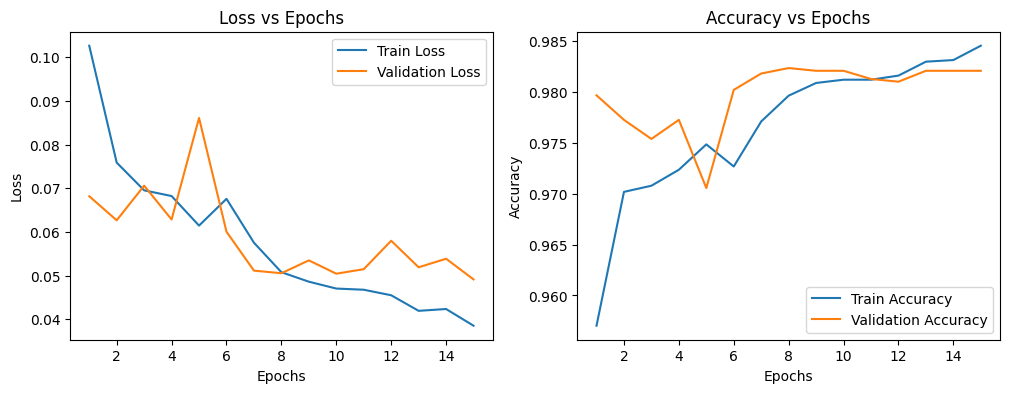

In [11]:
# Step 6: Plot the training and validation losses and accuracies
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()

    plt.show()

# Plot the metrics
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)